In [ ]:
pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Wind Power Data

In [ ]:
ActualWindPower = pd.read_csv('Actual wind power.csv', sep = ';')
# DayAheadPrice = pd.read_excel('Day-ahead price.xlsx')
# DownReg2021 = pd.read_csv('Down-regulation price_2021.csv')
# DownReg2022 = pd.read_csv('Down-regulation price_2022.csv')
# UpReg2021 = pd.read_csv('Up-regulation price_2021.csv')
# UpReg2022 = pd.read_csv('Up-regulation price_2022.csv')


Here I compute the quantiles for the past week for each of the times. For all the values with an index lower than 24*7, an interpolation is made in order to have a value (to be approved by the group).

In [ ]:
#ActualWindPower['Quantile_0.05'] = ActualWindPower['Actual'].rolling(window=7*24, min_periods=1).quantile(0.05)
#ActualWindPower['Quantile_0.5'] = ActualWindPower['Actual'].rolling(window=7*24, min_periods=1).quantile(0.5)
#ActualWindPower['Quantile_0.95'] = ActualWindPower['Actual'].rolling(window=7*24, min_periods=1).quantile(0.95)

In [ ]:
window_size = 24 * 7

#Removing duplicates and choosing our time 
start_date = '2021-01-01 00:00:00'
end_date = '2022-12-31 21:00:00'
ActualWindPower = pd.read_csv('Actual wind power.csv', sep = ';')
ActualWindPower['Date'] = pd.to_datetime(ActualWindPower['Date'])
ActualWindPower['Time'] = pd.to_datetime(ActualWindPower['Time']).dt.time
ActualWindPower['Datetime'] = ActualWindPower.apply(lambda x: pd.datetime.combine(x['Date'], x['Time']), axis=1)
ActualWindPower = ActualWindPower.drop(['Date', 'Time'], axis=1)#.set_index("Datetime")
mask = (ActualWindPower['Datetime'] >= start_date) & (ActualWindPower['Datetime'] <= end_date)
ActualWindPower = ActualWindPower.loc[mask].drop_duplicates(subset=['Datetime'], keep='first').rename(columns = {"Datetime": "HourUTC"}).reset_index()



/tmp/ipykernel_130/1560753826.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ActualWindPower['Datetime'] = ActualWindPower.apply(lambda x: pd.datetime.combine(x['Date'], x['Time']), axis=1)


<AxesSubplot: >

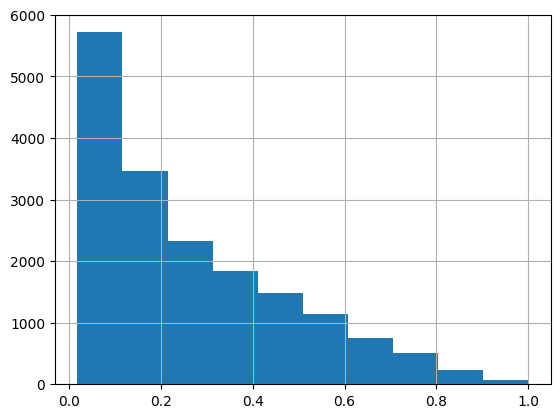

In [ ]:
ActualWindPower["Actual"].hist(bins=10)

In [ ]:
percentileValues005 = []
for i in range(len(ActualWindPower)):
    if i >= window_size:
        quantile_range=ActualWindPower['Actual'][i-window_size:i]
        percentile = quantile_range.quantile(0.05)
        percentileValues005.append(percentile)
    elif i > 0:
        percentileValues005.append(ActualWindPower['Actual'][0:i].quantile(0.05))
    else:
        percentileValues005.append(ActualWindPower['Actual'][0])
ActualWindPower['Quantile_0.05'] = percentileValues005

In [ ]:
percentileValues05 = []
for i in range(len(ActualWindPower)):
    if i >= window_size:
        quantile_range=ActualWindPower['Actual'][i-window_size:i]
        percentile = quantile_range.quantile(0.5)
        percentileValues05.append(percentile)
    elif i > 0:
        percentileValues05.append(ActualWindPower['Actual'][0:i].quantile(0.5))
    else:
        percentileValues05.append(ActualWindPower['Actual'][0])
ActualWindPower['Quantile_0.5'] = percentileValues05

In [ ]:
percentileValues095 = []
for i in range(len(ActualWindPower)):
    if i >= window_size:
        quantile_range=ActualWindPower['Actual'][i-window_size:i]
        percentile = quantile_range.quantile(0.95)
        percentileValues095.append(percentile)
    elif i > 0:
        percentileValues095.append(ActualWindPower['Actual'][0:i].quantile(0.95))
    else:
        percentileValues095.append(ActualWindPower['Actual'][0])
ActualWindPower['Quantile_0.95'] = percentileValues095

In [ ]:
#ActualWindPower['Actual'][0:168].quantile(0.95) #168th value: 0.65789473715
#ActualWindPower['Actual'][1:169].quantile(0.95) #169th value: 0.65789473715

# Roskilde Climate data

In [ ]:
df1 = pd.read_csv('roskilde_data_2021.csv')
df2 = pd.read_csv('roskilde_data_2022.csv')
df_cli = pd.concat([df1, df2])

df_cli = df_cli[df_cli['timeResolution'] == 'hour']
df_cli['Date'] = pd.to_datetime(df_cli["from"], format = '%Y-%m-%dT%H:%M:%S%z').dt.date
df_cli['Time'] = pd.to_datetime(df_cli["from"]).dt.time

df_cli = df_cli.pivot_table(index=['Date', 'Time'], columns='parameterId', values='value', aggfunc='first').reset_index()
df_cli['HourUTC'] = df_cli.apply(lambda x: pd.datetime.combine(x['Date'], x['Time']), axis=1)


/tmp/ipykernel_130/2763711825.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_cli['HourUTC'] = df_cli.apply(lambda x: pd.datetime.combine(x['Date'], x['Time']), axis=1)


<AxesSubplot: >

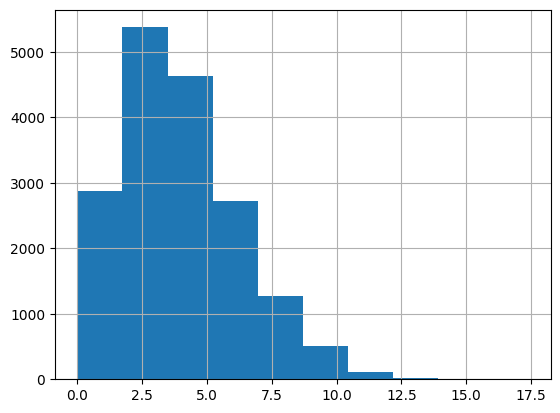

In [ ]:
df_cli["mean_wind_speed"].hist(bins=10)

In [ ]:
#def format_datetime(datetime_str):
#    parsed_datetime = datetime.fromisoformat(datetime_str[:-6])
#    formatted_date = parsed_datetime.strftime("%d.%m.%Y")
#    formatted_time = parsed_datetime.strftime("%H:%M")
#    return formatted_date, formatted_time

# Apply the function to the DataFrame and create new columns
#df[['Date', 'Time']] = df['from'].apply(format_datetime).apply(pd.Series)

In [ ]:
#def format_datetime(datetime_str):
#    parsed_datetime = datetime.fromisoformat(datetime_str[:-6])
#    formatted_date = parsed_datetime.strftime("%d.%m.%Y")
#    formatted_time = parsed_datetime.strftime("%H:%M")
#    return formatted_date, formatted_time

# Apply the function to the DataFrame and create new columns
#df[['Date', 'Time']] = df['to'].apply(format_datetime).apply(pd.Series)

# Merge both datasets

In [ ]:
Wind_data = ActualWindPower.copy()

In [ ]:
Combined_data = df_cli.merge(Wind_data, on=['HourUTC'])
Combined_data = Combined_data.drop(["Date", "Time","Actual","index"], axis = "columns").set_index("HourUTC")

In [ ]:
#scaler = preprocessing.StandardScaler().fit(Combined_data)
scaler = MinMaxScaler().fit(Combined_data)
Scaled_data = pd.DataFrame(scaler.transform(Combined_data),columns= (Combined_data.columns))
# Extract the day, month, and year components from the datetime object
Scaled_data['year'] = Combined_data.index.year
Scaled_data['month'] = Combined_data.index.month
Scaled_data['day'] = Combined_data.index.day
Scaled_data['hour'] = Combined_data.index.hour
Scaled_data["HourUTC"] = Combined_data.index
Scaled_data["Actual"] = Wind_data["Actual"]

In [ ]:
#Creates seasons
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

month_to_season = dict(zip(range(1,13), seasons))

Scaled_data["Seasons"] = Scaled_data['HourUTC'].dt.month.map(month_to_season)

In [ ]:
Scaled_data

,acc_precip,bright_sunshine,leaf_moisture,max_temp_w_date,max_wind_speed_10min,max_wind_speed_3sec,mean_cloud_cover,mean_pressure,mean_radiation,mean_relative_hum,...,Quantile_0.05,Quantile_0.5,Quantile_0.95,year,month,day,hour,HourUTC,Actual,Seasons
0,0.000000,0.0,0.766667,0.300971,0.206731,0.242321,0.98,0.434307,0.000113,0.899721,...,0.773143,0.381303,0.251156,2021,1,1,0,2021-01-01 00:00:00,0.290185,1
1,0.000000,0.0,0.856667,0.303398,0.158654,0.174061,1.00,0.434307,0.000113,0.902507,...,0.773143,0.381303,0.251156,2021,1,1,1,2021-01-01 01:00:00,0.258890,1
2,0.000000,0.0,0.846667,0.308252,0.211538,0.197952,0.99,0.435523,0.000113,0.884401,...,0.688098,0.358193,0.249306,2021,1,1,2,2021-01-01 02:00:00,0.234708,1
3,0.006993,0.0,0.855000,0.305825,0.206731,0.191126,0.99,0.435523,0.000113,0.910864,...,0.621363,0.335084,0.247456,2021,1,1,3,2021-01-01 03:00:00,0.223329,1
4,0.013986,0.0,0.856667,0.296117,0.206731,0.208191,0.99,0.435523,0.000113,0.922006,...,0.586775,0.317227,0.245607,2021,1,1,4,2021-01-01 04:00:00,0.172119,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17512,0.006993,0.0,0.643333,0.487864,0.317308,0.337884,1.00,0.386861,0.000000,0.945682,...,0.281180,0.753151,0.830741,2022,12,31,17,2022-12-31 17:00:00,0.568990,1
17513,0.006993,0.0,0.570000,0.487864,0.307692,0.313993,1.00,0.394161,0.000000,0.931755,...,0.281180,0.753151,0.830741,2022,12,31,18,2022-12-31 18:00:00,0.537696,1
17514,0.013986,0.0,0.850000,0.480583,0.230769,0.262799,1.00,0.402676,0.000000,0.934540,...,0.281180,0.753151,0.830741,2022,12,31,19,2022-12-31 19:00:00,0.453770,1
17515,0.048951,0.0,0.851667,0.470874,0.187500,0.218430,0.99,0.407543,0.000000,0.952646,...,0.281180,0.753151,0.830741,2022,12,31,20,2022-12-31 20:00:00,0.354196,1


# Push data into csv file when checked

## /!\ Don't forget to comment the line of code when it's done

In [ ]:
#Write to csv
Scaled_data.to_csv("Processed_data.csv")

# Balance Prices data 

In [ ]:
#DayAheadPrice = pd.read_excel('Day-ahead price.xlsx')
#Instead we use directly the EUR data from the same time period (new data set )

# We still use the Fin grid balancing data
DownReg2021 = pd.read_csv('Down-regulation price_2021.csv')
DownReg2022 = pd.read_csv('Down-regulation price_2022.csv')
UpReg2021 = pd.read_csv('Up-regulation price_2021.csv')
UpReg2022 = pd.read_csv('Up-regulation price_2022.csv')

Upreg = pd.concat([UpReg2021,UpReg2022],axis=0).rename(columns={"Start time UTC": "HourUTC","Up-regulating price in the Balancing energy market" : "Up-regulating_price"})
Downreg = pd.concat([DownReg2021,DownReg2022],axis = 0).rename(columns={"Start time UTC": "HourUTC","Down-regulation price in the Balancing energy market" : "Down-regulating_price"})

Upreg["HourUTC"] = pd.to_datetime(Upreg["HourUTC"],format='%d/%m/%Y %H.%M')
Downreg["HourUTC"] = pd.to_datetime(Downreg["HourUTC"],format='%d/%m/%Y %H.%M')

DayAheadPrice = pd.read_excel("Day-ahead price.xlsx")
DayAheadPrice = DayAheadPrice[DayAheadPrice['PriceArea'] == 'DK2'].drop(columns = ["HourDK","SpotPriceDKK","PriceArea"]).reset_index(drop=True)


mask = (DayAheadPrice['HourUTC'] >= start_date) & (DayAheadPrice['HourUTC'] <= end_date)
DayAheadPrice_df = DayAheadPrice.loc[mask]

DayAheadPrice_df = DayAheadPrice_df.merge(Upreg[["HourUTC","Up-regulating_price"]], how='inner', on='HourUTC')
DayAheadPrice_df = DayAheadPrice_df.merge(Downreg[["HourUTC","Down-regulating_price"]], how='inner', on='HourUTC')
#Ugly hardcoded but this is the missing data 
missing = '2022-01-01 00:00'
DayAheadPrice_df = DayAheadPrice_df.loc[DayAheadPrice_df["HourUTC"] != missing ].reset_index()


#Write price dataframe to csv and use that 

DayAheadPrice_df.to_csv("Prices_processed.csv")




## Investigation of hours with regards to Wind and prices 

In [ ]:
#Missing data investigation and duplicates
ActualWindPower.duplicated(subset=['HourUTC'])

dupli_1 = "2021-10-31 02:00:00"
dupli_2 = "2022-10-30 03:00:00"
print(ActualWindPower.loc[ActualWindPower['HourUTC'] == dupli_1])

print(ActualWindPower.loc[ActualWindPower['HourUTC'] == dupli_2])
result_df = pd.merge(DayAheadPrice_df,ActualWindPower,how='outer', on ="HourUTC")
result_df.sort_values(by='HourUTC',ascending=True, inplace=True)

result_df[result_df['Actual'].isna()]

      index    Actual             HourUTC  Quantile_0.05  Quantile_0.5  \
7274   7274  0.338549 2021-10-31 02:00:00       0.136131      0.263158   

      Quantile_0.95  
7274       0.503912  
       index   Actual             HourUTC  Quantile_0.05  Quantile_0.5  \
16010  16011  0.13798 2022-10-30 03:00:00       0.067354      0.187055   

       Quantile_0.95  
16010        0.39111  


,index_x,HourUTC,SpotPriceEUR,Up-regulating_price,Down-regulating_price,index_y,Actual,Quantile_0.05,Quantile_0.5,Quantile_0.95


In [ ]:
Scaled_data['HourUTC'].dt.date[1416]

datetime.date(2021, 3, 1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=538942fa-4593-4d1a-b90d-2d23669fe78c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>